In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
from windrose import WindroseAxes

In [2]:
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

# --- Step 2: Load dataset ---
file_path = '../data/raw/togo-dapaong_qc.csv'
df = pd.read_csv(file_path, parse_dates=['Timestamp'])
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (525600, 19)


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


In [3]:
df.describe(include='all')

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,525600,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,525600.000000,0.0
mean,2022-04-25 12:00:30.000000768,230.555040,151.258469,116.444352,226.144375,219.568588,27.751788,55.013160,2.368093,3.229490,0.557740,161.741845,10.559568,975.915242,0.000535,0.001382,32.444403,33.543330,NaN
min,2021-10-25 00:01:00,-12.700000,0.000000,0.000000,0.000000,0.000000,14.900000,3.300000,0.000000,0.000000,0.000000,0.000000,0.000000,968.000000,0.000000,0.000000,13.100000,13.100000,NaN
25%,2022-01-24 06:00:45,-2.200000,0.000000,0.000000,0.000000,0.000000,24.200000,26.500000,1.400000,1.900000,0.400000,74.800000,6.900000,975.000000,0.000000,0.000000,23.900000,23.600000,NaN
50%,2022-04-25 12:00:30,2.100000,0.000000,2.500000,4.400000,4.300000,27.200000,59.300000,2.200000,2.900000,0.500000,199.100000,10.800000,976.000000,0.000000,0.000000,28.400000,28.400000,NaN
75%,2022-07-25 18:00:15,442.400000,246.400000,215.700000,422.525000,411.000000,31.100000,80.800000,3.200000,4.400000,0.700000,233.500000,14.100000,977.000000,0.000000,0.000000,40.600000,43.000000,NaN
max,2022-10-25 00:00:00,1424.000000,1004.500000,805.700000,1380.000000,1367.000000,41.400000,99.800000,16.100000,23.100000,4.700000,360.000000,86.900000,983.000000,1.000000,2.300000,70.400000,94.600000,NaN
std,NaN,322.532347,250.956962,156.520714,317.346938,307.932510,4.758023,28.778732,1.462668,1.882565,0.268923,91.877217,5.915490,2.153977,0.023116,0.026350,10.998334,12.769277,NaN


In [4]:
# --- Missing Values ---
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (df.isna().mean() * 100).sort_values(ascending=False)
missing_report = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})

# Filter columns with more than 5% missing values
filtered_missing = missing_report[missing_report['Missing %'] > 5]

# Print report
print("\n--- Missing Values Report (Columns > 5% Missing) ---")
print(filtered_missing)



--- Missing Values Report (Columns > 5% Missing) ---
          Missing Count  Missing %
Comments         525600      100.0


In [5]:
import os
cols = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# --- Convert numeric safely ---
for c in cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# --- Remove impossible negative solar irradiance values ---
df.loc[df['GHI'] < 0, 'GHI'] = np.nan
df.loc[df['DNI'] < 0, 'DNI'] = np.nan
df.loc[df['DHI'] < 0, 'DHI'] = np.nan

# --- Fill missing values with median (no row drop yet) ---
for c in cols:
    df[c] = df[c].fillna(df[c].median())

# --- Compute Z-scores and flag outliers ---
z_scores = np.abs(stats.zscore(df[cols], nan_policy='omit'))
z_df = pd.DataFrame(z_scores, columns=cols, index=df.index)

outliers = (z_df > 3).sum()
print("Outlier count per column:")
print(outliers)

df['is_outlier'] = (z_df > 3).any(axis=1)
print(f"Total outlier rows flagged: {df['is_outlier'].sum()}")

# --- Optional: Replace outliers with median instead of dropping ---
for c in cols:
    median_val = df[c].median()
    df.loc[df['is_outlier'], c] = median_val

# --- Ensure folder exists and save cleaned data ---
clean_path = '../data/cleaned/togo_clean.csv'
os.makedirs(os.path.dirname(clean_path), exist_ok=True)

print("DataFrame shape before saving:", df.shape)
df.to_csv(clean_path, index=False)
print(f"✅ Cleaned data exported to {os.path.abspath(clean_path)}")

Outlier count per column:
GHI        997
DNI       1062
DHI       3415
ModA       137
ModB       206
WS        3510
WSgust    3915
dtype: int64
Total outlier rows flagged: 9852
DataFrame shape before saving: (525600, 20)
✅ Cleaned data exported to d:\AI mastery\solar-challenge-week1\data\cleaned\togo_clean.csv


d:\AI mastery\solar-challenge-week1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


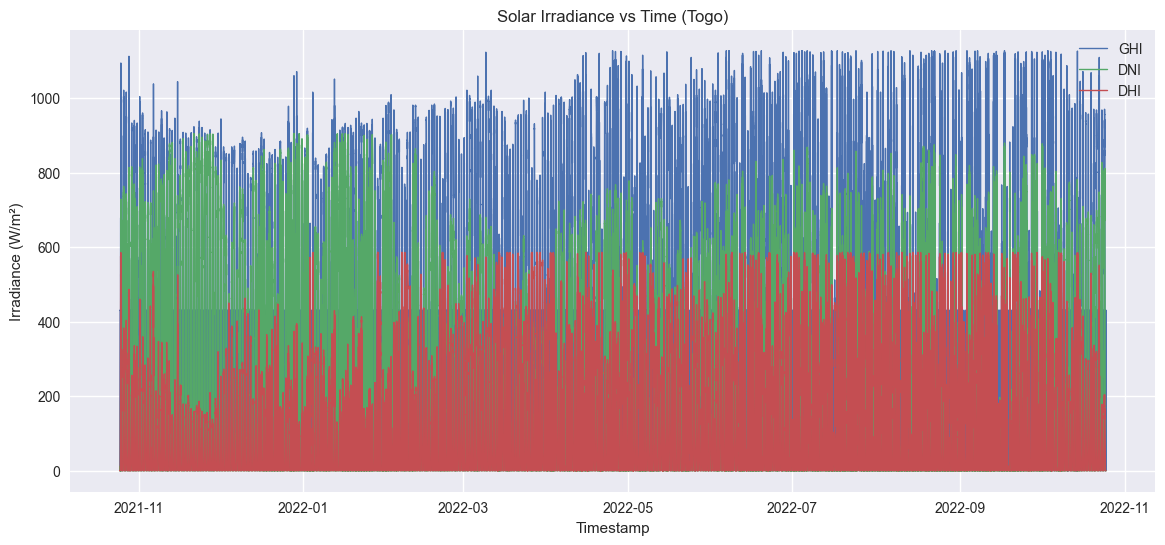

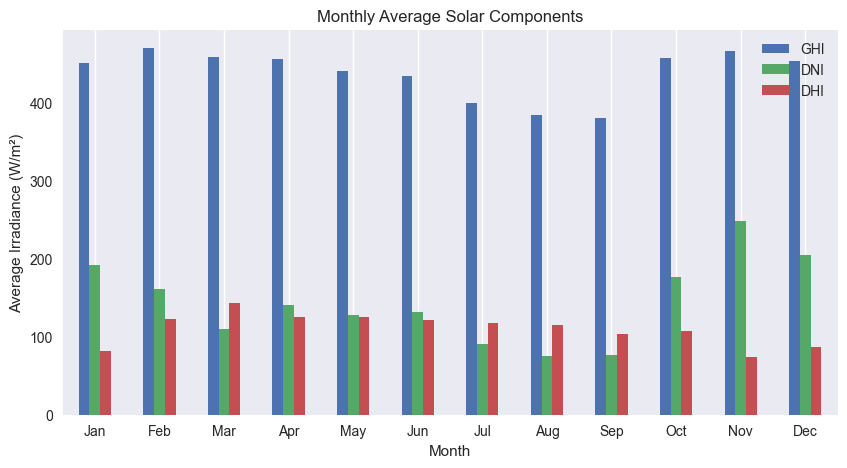

In [6]:
plt.figure(figsize=(14,6))
plt.plot(df['Timestamp'], df['GHI'], label='GHI', linewidth=1)
plt.plot(df['Timestamp'], df['DNI'], label='DNI', linewidth=1)
plt.plot(df['Timestamp'], df['DHI'], label='DHI', linewidth=1)
plt.legend()
plt.title('Solar Irradiance vs Time (Togo)')
plt.xlabel('Timestamp')
plt.ylabel('Irradiance (W/m²)')
plt.grid(True)
plt.show()

# --- Monthly Average Solar Components ---
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df['Month'] = df['Timestamp'].dt.month

# Compute monthly averages
monthly_avg = df.groupby('Month')[['GHI', 'DNI', 'DHI']].mean()

# Optional: Rename months for clarity
month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
               7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
monthly_avg.index = monthly_avg.index.map(month_names)

# Plot monthly averages only if data is not empty
if not monthly_avg.empty:
    monthly_avg.plot(kind='bar', figsize=(10,5), title='Monthly Average Solar Components', rot=0)
    plt.xlabel('Month')
    plt.ylabel('Average Irradiance (W/m²)')
    plt.grid(axis='y')
    plt.show()
else:
    print("⚠️ No data available for monthly average plot.")

                ModA        ModB
Cleaning                        
0         214.209279  207.980849
1         510.098577  508.594306


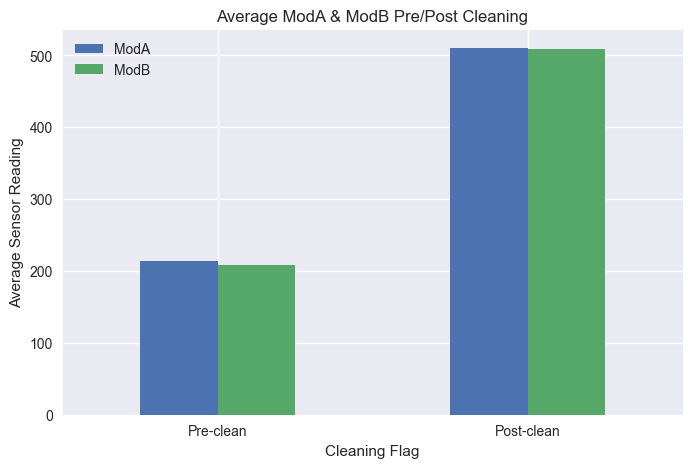

In [7]:
clean_path = '../data/cleaned/togo_clean.csv'
df = pd.read_csv(clean_path)

# --- Ensure numeric columns are properly typed ---
df['ModA'] = pd.to_numeric(df['ModA'], errors='coerce')
df['ModB'] = pd.to_numeric(df['ModB'], errors='coerce')
df['Cleaning'] = pd.to_numeric(df['Cleaning'], errors='coerce')

# --- Fill any missing sensor values with median ---
df['ModA'] = df['ModA'].fillna(df['ModA'].median())
df['ModB'] = df['ModB'].fillna(df['ModB'].median())

# --- Group by Cleaning flag ---
cleaning_group = df.groupby('Cleaning')[['ModA', 'ModB']].mean()
print(cleaning_group)

# --- Plot average ModA & ModB pre/post-clean ---
ax = cleaning_group.plot(kind='bar', figsize=(8,5), rot=0)
ax.set_title('Average ModA & ModB Pre/Post Cleaning')
ax.set_xlabel('Cleaning Flag')
ax.set_ylabel('Average Sensor Reading')
plt.xticks([0,1], ['Pre-clean', 'Post-clean'], rotation=0)
plt.legend(['ModA', 'ModB'])
plt.show()


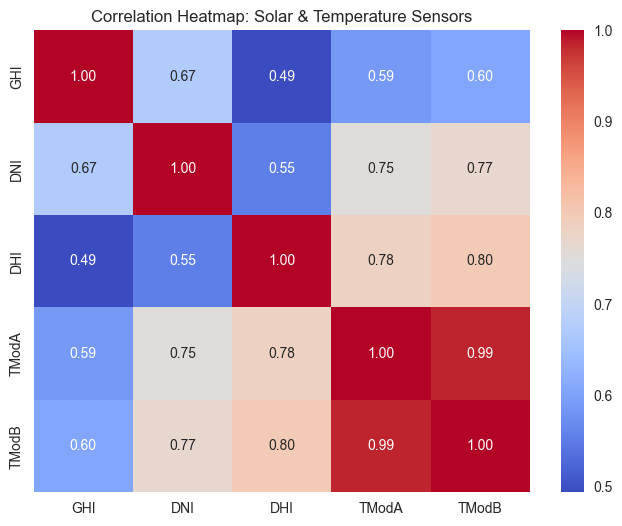

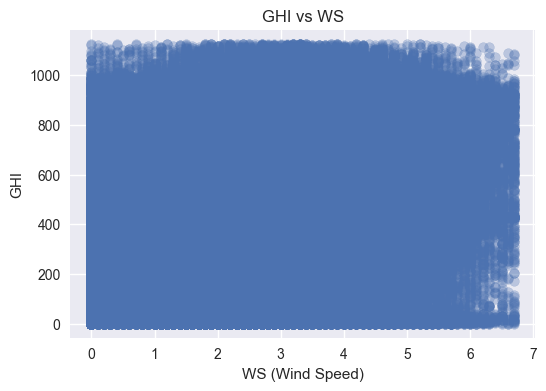

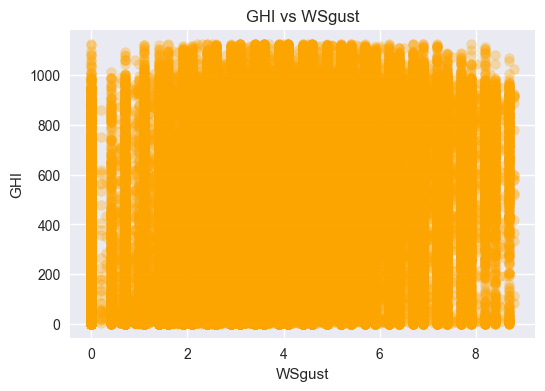

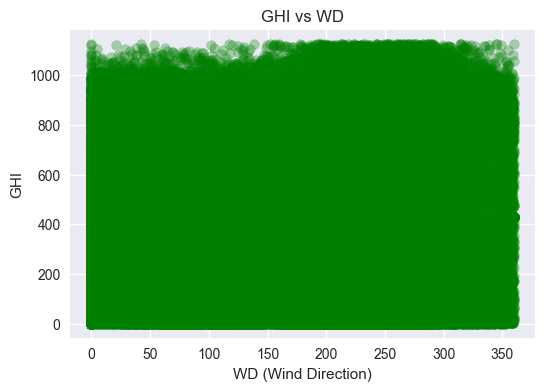

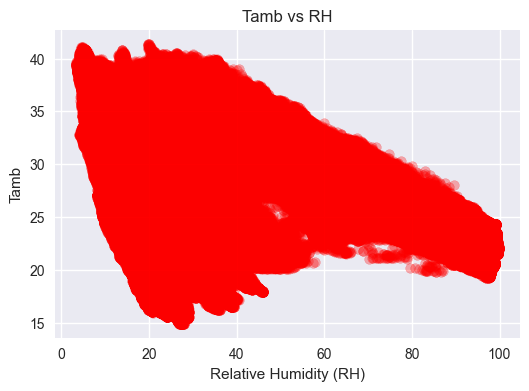

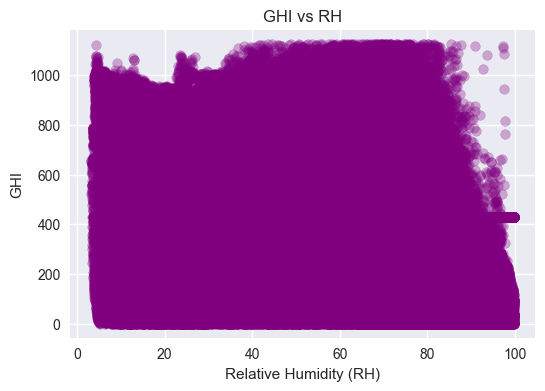

In [8]:
clean_path = '../data/cleaned/togo_clean.csv'
df = pd.read_csv(clean_path)

# --- Ensure numeric columns are numeric ---
numeric_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'WS', 'WSgust', 'WD', 'RH', 'Tamb']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing numeric values for correlation
df_corr = df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].dropna()

# --- 1. Heatmap of correlations ---
plt.figure(figsize=(8,6))
corr_matrix = df_corr.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap: Solar & Temperature Sensors')
plt.show()

# --- 2. Scatter plots -- relationships ---

# WS vs GHI
plt.figure(figsize=(6,4))
plt.scatter(df['WS'], df['GHI'], alpha=0.3)
plt.xlabel('WS (Wind Speed)')
plt.ylabel('GHI')
plt.title('GHI vs WS')
plt.show()

# WSgust vs GHI
plt.figure(figsize=(6,4))
plt.scatter(df['WSgust'], df['GHI'], alpha=0.3, color='orange')
plt.xlabel('WSgust')
plt.ylabel('GHI')
plt.title('GHI vs WSgust')
plt.show()

# WD vs GHI
plt.figure(figsize=(6,4))
plt.scatter(df['WD'], df['GHI'], alpha=0.3, color='green')
plt.xlabel('WD (Wind Direction)')
plt.ylabel('GHI')
plt.title('GHI vs WD')
plt.show()

# RH vs Tamb
plt.figure(figsize=(6,4))
plt.scatter(df['RH'], df['Tamb'], alpha=0.3, color='red')
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('Tamb')
plt.title('Tamb vs RH')
plt.show()

# RH vs GHI
plt.figure(figsize=(6,4))
plt.scatter(df['RH'], df['GHI'], alpha=0.3, color='purple')
plt.xlabel('Relative Humidity (RH)')
plt.ylabel('GHI')
plt.title('GHI vs RH')
plt.show()

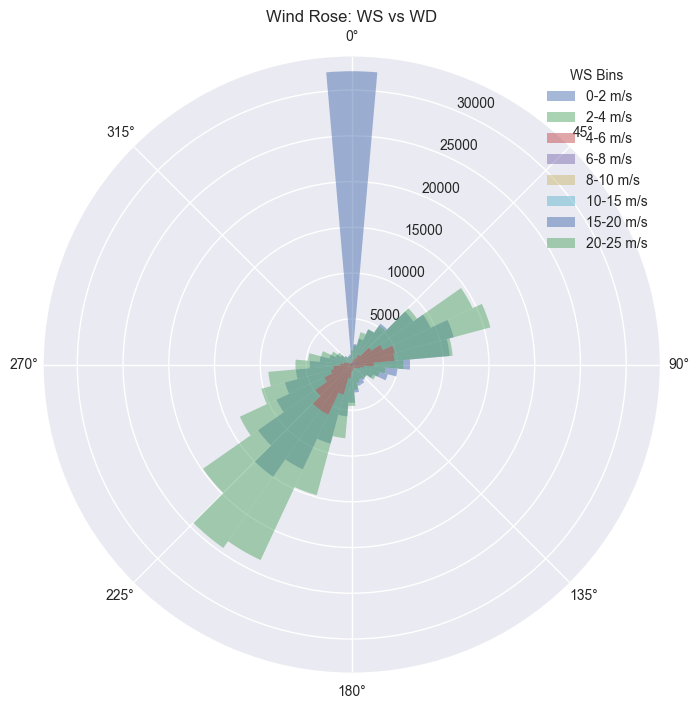

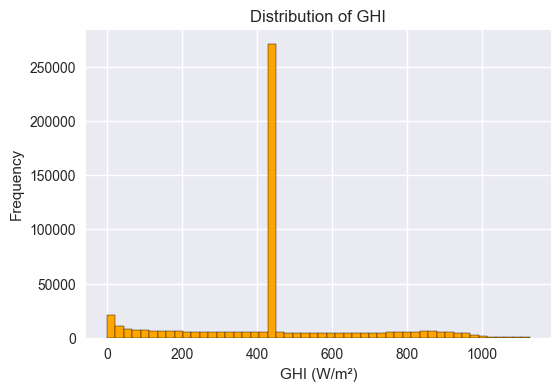

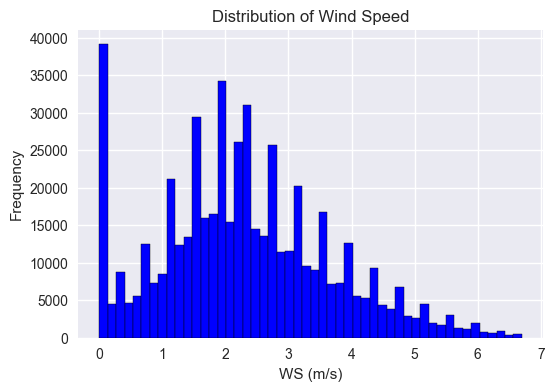

In [9]:
numeric_cols = ['WS', 'WD', 'GHI']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing WS or WD
df_wind = df[['WS', 'WD']].dropna()

# --- 1. Wind rose (radial bar plot) ---
# Convert WD to radians
wd_rad = np.deg2rad(df_wind['WD'])
ws = df_wind['WS']

# Create bins for WS
ws_bins = [0, 2, 4, 6, 8, 10, 15, 20, 25]
ws_labels = range(len(ws_bins)-1)
df_wind['WS_bin'] = pd.cut(ws, bins=ws_bins, labels=ws_labels, right=False)

# Prepare polar plot
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

# Aggregate counts by WD and WS_bin
for i in ws_labels:
    ws_subset = df_wind[df_wind['WS_bin'] == i]
    counts, bin_edges = np.histogram(np.deg2rad(ws_subset['WD']), bins=36)
    ax.bar(bin_edges[:-1], counts, width=np.deg2rad(10), bottom=0, alpha=0.5, label=f'{ws_bins[i]}-{ws_bins[i+1]} m/s')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
plt.title('Wind Rose: WS vs WD')
plt.legend(title='WS Bins')
plt.show()

# --- 2. Histograms ---

# GHI histogram
plt.figure(figsize=(6,4))
plt.hist(df['GHI'].dropna(), bins=50, color='orange', edgecolor='black')
plt.xlabel('GHI (W/m²)')
plt.ylabel('Frequency')
plt.title('Distribution of GHI')
plt.show()

# WS histogram
plt.figure(figsize=(6,4))
plt.hist(df['WS'].dropna(), bins=50, color='blue', edgecolor='black')
plt.xlabel('WS (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Wind Speed')
plt.show()

C:\Users\YASMIN\AppData\Local\Temp\ipykernel_40868\3584782855.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


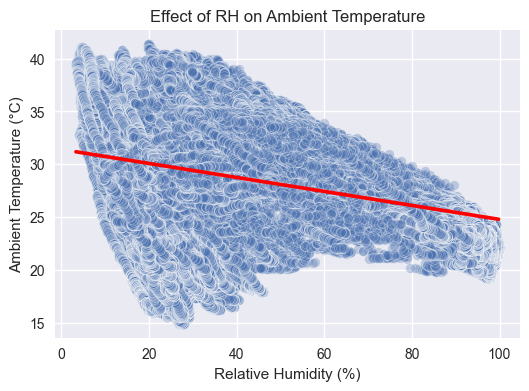

C:\Users\YASMIN\AppData\Local\Temp\ipykernel_40868\3584782855.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
d:\AI mastery\solar-challenge-week1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


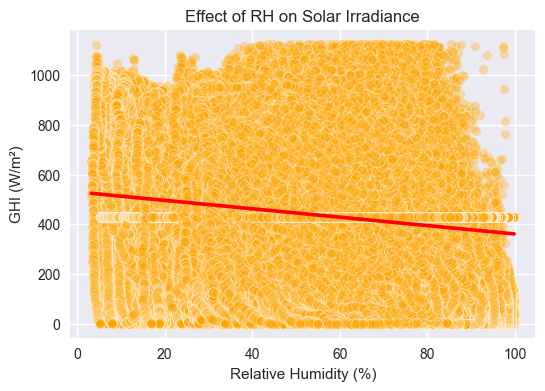

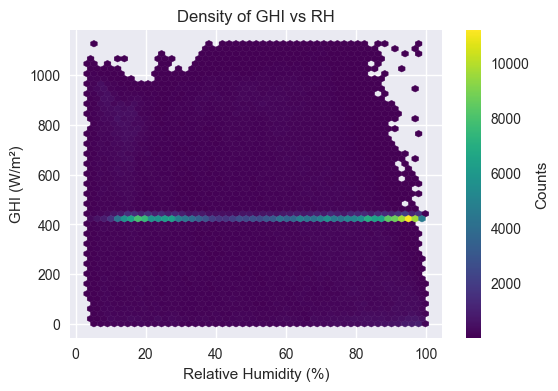

In [10]:
# Ensure numeric columns
numeric_cols = ['Tamb', 'GHI', 'RH']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing values
df_analysis = df[['Tamb', 'GHI', 'RH']].dropna()

# --- 1. Scatter plot: RH vs Tamb ---
plt.figure(figsize=(6,4))
sns.scatterplot(x='RH', y='Tamb', data=df_analysis, alpha=0.3)
sns.regplot(x='RH', y='Tamb', data=df_analysis, scatter=False, color='red', line_kws={'label':'Trend Line'})
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.title('Effect of RH on Ambient Temperature')
plt.legend()
plt.show()

# --- 2. Scatter plot: RH vs GHI ---
plt.figure(figsize=(6,4))
sns.scatterplot(x='RH', y='GHI', data=df_analysis, alpha=0.3, color='orange')
sns.regplot(x='RH', y='GHI', data=df_analysis, scatter=False, color='red', line_kws={'label':'Trend Line'})
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.title('Effect of RH on Solar Irradiance')
plt.legend()
plt.show()

# --- 3. Optional: Hexbin plot for density visualization ---
plt.figure(figsize=(6,4))
plt.hexbin(df_analysis['RH'], df_analysis['GHI'], gridsize=50, cmap='viridis', mincnt=1)
plt.colorbar(label='Counts')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.title('Density of GHI vs RH')
plt.show()

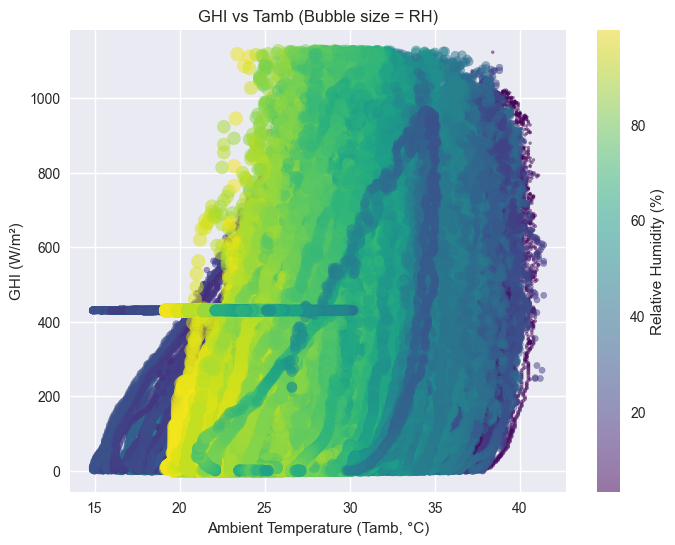

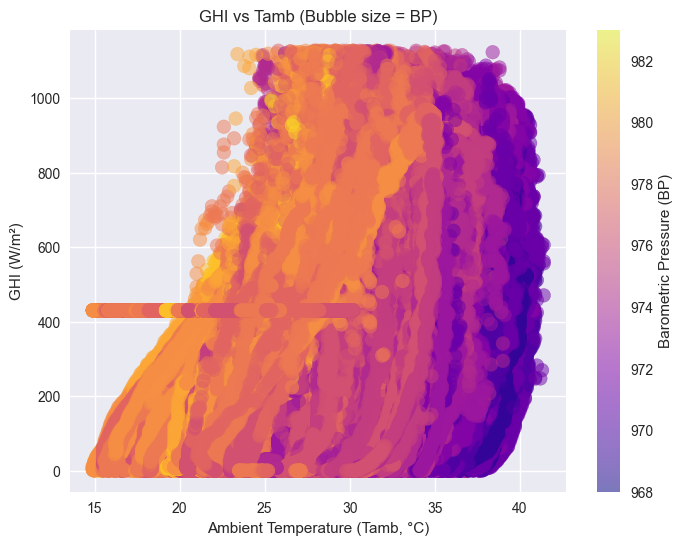

In [11]:
numeric_cols = ['GHI', 'Tamb', 'RH', 'BP']
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop rows with missing values
df_bubble = df[['GHI', 'Tamb', 'RH', 'BP']].dropna()

# --- Bubble Chart: GHI vs Tamb with bubble size = RH ---
plt.figure(figsize=(8,6))
plt.scatter(
    df_bubble['Tamb'], 
    df_bubble['GHI'], 
    s=df_bubble['RH'],  # Bubble size
    c=df_bubble['RH'],  # Bubble color
    cmap='viridis', 
    alpha=0.5
)
plt.xlabel('Ambient Temperature (Tamb, °C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs Tamb (Bubble size = RH)')
plt.colorbar(label='Relative Humidity (%)')
plt.show()

# --- Optional: Bubble Chart with BP instead of RH ---
plt.figure(figsize=(8,6))
plt.scatter(
    df_bubble['Tamb'], 
    df_bubble['GHI'], 
    s=(df_bubble['BP']/10),  # Scale down pressure for bubble size
    c=df_bubble['BP'], 
    cmap='plasma', 
    alpha=0.5
)
plt.xlabel('Ambient Temperature (Tamb, °C)')
plt.ylabel('GHI (W/m²)')
plt.title('GHI vs Tamb (Bubble size = BP)')
plt.colorbar(label='Barometric Pressure (BP)')
plt.show()